# DL_HW3

In [1]:
import numpy as np
import pandas as pd
import os, cv2, time
from imageio import imread, imwrite
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
# from .autonotebook import tqdm as notebook_tqdm
import multiprocessing
from multiprocessing import Pool

import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.nn.functional as F

# prune
import torch.nn.utils.prune as prune


/home/rita/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cpus = multiprocessing.cpu_count()
print(cpus)
print(torch.cuda.is_available()) 
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

160
True
Training on device cuda.


## Read Data

In [3]:
# 讀取圖片function
def read_img(path) :
    img = cv2.imread(path)
    img = cv2.resize(img, (256, 256))
    return img

def read_img_32(path) :
    img = cv2.imread(path)
    img = cv2.resize(img, (32, 32))
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

# onehot
def self_onehot(x, c = 50) : 
    x_onehot = np.zeros([x.shape[0], c])
    for i in range(x.shape[0]) :
        x_onehot[i, int(x[i])] = 1
    return x_onehot

In [4]:
# 讀取index
os.chdir('/home/rita/111/111-2DL/HW1')
train_idx = np.array(pd.read_table('train.txt', header = None, sep = ' '))
val_idx = np.array(pd.read_table('val.txt', header = None, sep = ' '))
test_idx = np.array(pd.read_table('test.txt', header = None, delimiter = ' '))
train_y = train_idx[::, 1].astype(float)
val_y = val_idx[::, 1].astype(float)
test_y = test_idx[::, 1].astype(float)
train_onehot_y = self_onehot(train_y)
val_onehot_y = self_onehot(val_y)
test_onehot_y = self_onehot(test_y)

with Pool(processes = 80) as p:
    train_pic = list(tqdm(p.imap(read_img_32, train_idx[::, 0], chunksize=100), total = train_idx.shape[0]))
    val_pic = list(tqdm(p.imap(read_img_32, val_idx[::, 0], chunksize=100), total = val_idx.shape[0]))
    test_pic = list(tqdm(p.imap(read_img_32, test_idx[::, 0], chunksize=100), total = test_idx.shape[0]))

train_pic = np.array(train_pic)
val_pic = np.array(val_pic)
test_pic = np.array(test_pic)

os.chdir('/home/rita/111/111-2DL/HW3')

100%|██████████| 450/450 [00:00<00:00, 3460.89it/s]


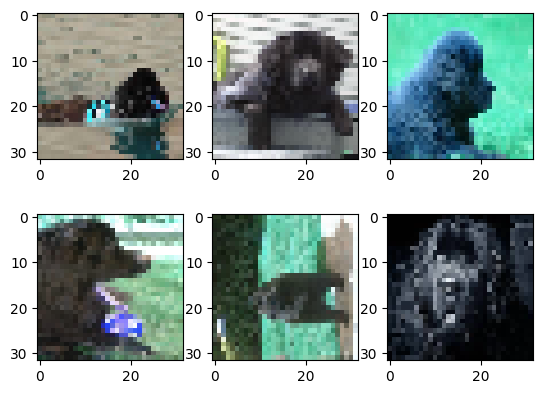

In [5]:
# print img
plt.subplot(2, 3, 1)
img = Image.fromarray(train_pic[0].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 2)
img = Image.fromarray(val_pic[0].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 3)
img = Image.fromarray(test_pic[0].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 4)
img = Image.fromarray(train_pic[1].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 5)
img = Image.fromarray(val_pic[1].astype(np.uint8))
plt.imshow(img)
plt.subplot(2, 3, 6)
img = Image.fromarray(test_pic[1].astype(np.uint8))
plt.imshow(img)

## PyTorch Lenet5

In [6]:
train_x = train_pic
val_x = val_pic
test_x = test_pic

train_x_tensor = torch.tensor(train_x).to(torch.float32)
val_x_tensor = torch.tensor(val_x).to(torch.float32)
test_x_tensor = torch.tensor(test_x).to(torch.float32)

train_x_tensor = torch.permute(train_x_tensor, (0, 3, 1, 2))
val_x_tensor = torch.permute(val_x_tensor, (0, 3, 1, 2))
test_x_tensor = torch.permute(test_x_tensor, (0, 3, 1, 2))

train_y_tensor = torch.tensor(train_y).to(torch.float32)
val_y_tensor = torch.tensor(val_y).to(torch.float32)
test_y_tensor = torch.tensor(test_y).to(torch.float32)

train_dataset_tensor = Data.TensorDataset(train_x_tensor, train_y_tensor)
val_dataset_tensor = Data.TensorDataset(val_x_tensor, val_y_tensor)
test_dataset_tensor = Data.TensorDataset(test_x_tensor, test_y_tensor)

batch_size = 32
train_loader = DataLoader(
    dataset = train_dataset_tensor,
    batch_size = batch_size,
    shuffle = True,
    # num_workers = 4
)

val_loader = DataLoader(
    dataset = val_dataset_tensor,
    batch_size = batch_size,
    shuffle = False,
    # num_workers = 4
)

test_loader = DataLoader(
    dataset = test_dataset_tensor,
    batch_size = batch_size,
    shuffle = False,
    # num_workers = 4
)

print(type(train_dataset_tensor))
print(type(train_x_tensor))
print(torch.__version__)

<class 'torch.utils.data.dataset.TensorDataset'>
<class 'torch.Tensor'>
1.13.0+cu117


In [7]:
class Lenet5_PyTorch(nn.Module) :
    def __init__(self, n_channel = 6):
        super().__init__() # (3, 32, 32)
        self.n_channel = n_channel
        self.conv1 = nn.Conv2d(3, 6, kernel_size = 5) # (6, 28, 28)
        # self.conv1_bn = nn.BatchNorm2d()
        self.conv2 = nn.Conv2d(6, 16, kernel_size = 5) # (16, 10, 10)
        # self.conv2_bn = nn.BatchNorm2d()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 50)
    
    def forward(self, x) :
        out = F.max_pool2d(torch.sigmoid(self.conv1(x)), 2) # (6, 14, 14)
        # out = nn.functional.relu(self.conv1_bn(out))
        out = F.max_pool2d(torch.sigmoid(self.conv2(out)), 2) # (16, 5, 5)
        # out = nn.functional.relu(self.conv2_bn(out))
        out = out.view(out.size(0), -1)
        out = torch.sigmoid(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))
        out = torch.softmax(self.fc3(out), dim = 1)
        return out

In [8]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader = None):
    ls_train_loss = []
    ls_train_acc = []
    ls_val_loss = []
    ls_val_acc = []
    for epoch in range(1, n_epochs + 1):
        train_acc = 0
        train_loss = 0
        val_acc = 0
        val_loss = 0
        correct = 0
        total = 0
        
        loop = tqdm(enumerate(train_loader), total = len(train_loader))
        for i, (imgs, labels) in loop : 
            imgs = imgs.to(device = device) 
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device = device)
            batch_size = imgs.shape[0]
            outputs = model(imgs)
            loss = loss_fn(outputs, labels) 
            
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step() 
            
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0] 
            correct += int((predicted == labels).sum())
            train_loss += loss.item() * labels.shape[0]
            
            loop.set_description(f'Epoch[{epoch} / {n_epochs}]')
            if ((i+1 == len(train_loader)) and (val_loader != None)) :
                train_acc = correct / total
                train_loss /= total
                val_acc, val_loss = validate(model, loss_fn, val_loader)
            
            loop.set_postfix(loss = train_loss, acc = train_acc, val_loss = val_loss, val_acc = val_acc)
        ls_train_acc.append(train_acc)
        ls_train_loss.append(train_loss)
        ls_val_acc.append(val_acc)
        ls_val_loss.append(val_loss)
        
    return model, ls_train_acc, ls_train_loss, ls_val_acc, ls_val_loss
        
            
def validate(model, loss_fn, loader):
    correct = 0
    total = 0
    loss = 0
    with torch.no_grad(): 
        for imgs, labels in loader:
            imgs = imgs.to(device=device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device=device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0] 
            correct += int((predicted == labels).sum())
            loss += loss_fn(outputs, labels).item() * labels.shape[0]
            # print(predicted,  '\n')    
    acc = correct / total
    loss /= total
    # print("Accuracy : {:.2f}, Loss : {:.2f}".format(acc, loss)) 
        
    return acc, loss

In [9]:
# train a model
# save the trained model # (trained_model.model)
# load the trained model and prune it
# save the pruned model # (pruned_model.model)
# load the pruned model and train it

In [12]:
model = Lenet5_PyTorch().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)  
loss_fn = nn.CrossEntropyLoss() 
n_epochs = 5

model, ls_train_acc, ls_train_loss, ls_val_acc, ls_val_loss = training_loop( 
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader
)
torch.save(model.state_dict(), './model/cnn_adam_v1_prune.pt')
loaded_model = Lenet5_PyTorch()
loaded_model.load_state_dict(torch.load('./model/cnn_adam_v1_prune.pt'))
loaded_model.to(device)

tmp_module = loaded_model.fc1
prune.ln_structured(tmp_module, name="weight", amount=0.5, n = 1, dim = 1)
prune.remove(tmp_module, "weight")
torch.save(loaded_model.state_dict(), './model/cnn_adam_v1_afterprune.pt')
del model
model = Lenet5_PyTorch().to(device)
model.load_state_dict(torch.load('./model/cnn_adam_v1_afterprune.pt'))
prune.ln_structured(tmp_module, name="weight", amount=0.5, n = 1, dim = 1)
prune.remove(tmp_module, "weight")

Epoch[5 / 5]: 100%|██████████| 1979/1979 [00:08<00:00, 224.99it/s, acc=0.0624, loss=3.88, val_acc=0.0689, val_loss=3.87]


Linear(in_features=400, out_features=120, bias=True)

In [19]:
torch.save(model.state_dict(), './model/cnn_adam_v1_prune.pt')

In [17]:
print(loaded_model.parameters)
print(model.parameters)

<bound method Module.parameters of Lenet5_PyTorch(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=50, bias=True)
)>
<bound method Module.parameters of Lenet5_PyTorch(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=50, bias=True)
)>


In [20]:
loaded_model = Lenet5_PyTorch()
loaded_model.load_state_dict(torch.load('./model/cnn_adam_v1_prune.pt'))
loaded_model.to(device)
loaded_model.summary()

Lenet5_PyTorch(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=50, bias=True)
)

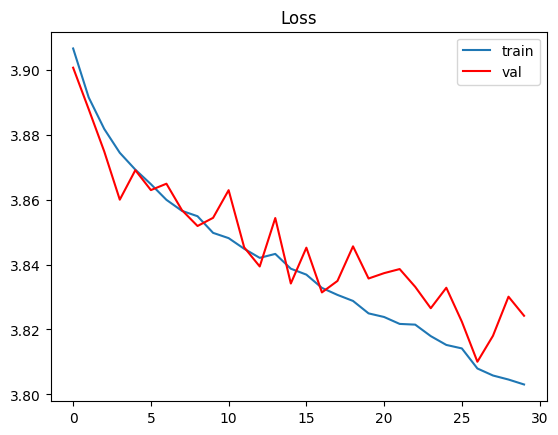

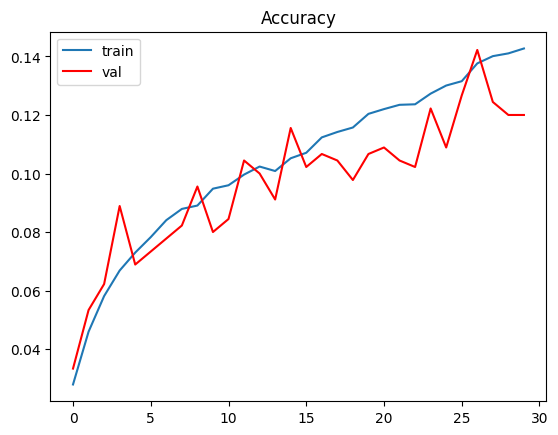

In [21]:
# plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(range(n_epochs), ls_train_loss, label="train")
plt.plot(range(n_epochs), ls_val_loss, label="val", c = 'red')
plt.legend()
plt.savefig('./figure/cnn_loss.png')
plt.show()
# plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(range(n_epochs), ls_train_acc, label="train")
plt.plot(range(n_epochs), ls_val_acc, label="val", c = 'red')
plt.legend()
plt.savefig('./figure/cnn_acc.png')
plt.show()

/tmp/ipykernel_1277469/1011390424.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread('./figure/cnn_loss.png')
/tmp/ipykernel_1277469/1011390424.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread('./figure/cnn_acc.png')


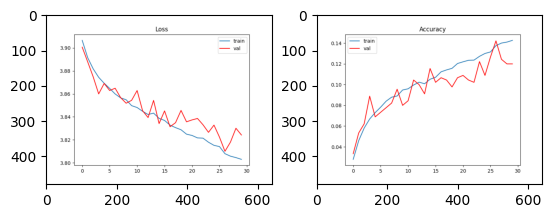

In [22]:
plt.subplot(1, 2, 1)
img = imread('./figure/cnn_loss.png')
plt.imshow(img)
plt.subplot(1, 2, 2)
img = imread('./figure/cnn_acc.png')
plt.imshow(img)

### Compare

In [19]:
import time
# https://github.com/sovrasov/flops-counter.pytorch
import torchvision.models as models
import torch

# https://www.zhihu.com/question/65305385
# FLOPS：floating point operations per second，意指每秒浮点运算次数，理解为计算速度。是一个衡量硬件性能的指标
# FLOPs：floating point operations的缩写（s表复数），意指浮点运算数，理解为计算量。可以用来衡量算法/模型的复杂度。
from ptflops import get_model_complexity_info



In [48]:
# Pytorch Lenet5
device = 'cpu'
loaded_model = Lenet5_PyTorch()
loaded_model.load_state_dict(torch.load('./model/cnn_adam_v1.pt'))
loaded_model = loaded_model.to(device)
loss_fn = nn.CrossEntropyLoss() 

# inference time
time_start = time.perf_counter()
acc, loss = validate(loaded_model, loss_fn, val_loader)
print("Time for PyTorch Lenet : {} s".format(time.perf_counter() - time_start))

# Accuracy
print('Accuracy for PyTorch Lenet : ', acc)
print('Loss for PyTorch Lenet : ', loss)

# space complexity
# https://github.com/sovrasov/flops-counter.pytorch
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(loaded_model, (3, 32, 32), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))



Time for PyTorch Lenet : 0.06065200502052903 s
Accuracy for PyTorch Lenet :  0.12
Loss for PyTorch Lenet :  3.8242185338338217
Lenet5_PyTorch(
  65.41 k, 100.000% Params, 661.64 KMac, 100.000% MACs, 
  (conv1): Conv2d(456, 0.697% Params, 357.5 KMac, 54.033% MACs, 3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2.42 k, 3.694% Params, 241.6 KMac, 36.515% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(48.12 k, 73.571% Params, 48.12 KMac, 7.273% MACs, in_features=400, out_features=120, bias=True)
  (fc2): Linear(10.16 k, 15.540% Params, 10.16 KMac, 1.536% MACs, in_features=120, out_features=84, bias=True)
  (fc3): Linear(4.25 k, 6.498% Params, 4.25 KMac, 0.642% MACs, in_features=84, out_features=50, bias=True)
)
Computational complexity:       661.64 KMac
Number of parameters:           65.41 k 
